# REINFORCE Tutorial <a id='toc'></a>

Here we provide from-scratch implementations (Parts 1 and 2) of REINFORCE as well as examples using an out-of-the-box package from OpenAI called Spinning Up (Part 3).

### <a href="0">0) Setup</a>
* <a href='#0.1'>0.1) Defining the RLAgent Class</a>
* <a href='#0.2'>0.2) Training function</a>
* <a href='#0.3'>0.3) A random agent</a>

### <a href='#1'> 1) REINFORCE: simplest implementation (no tensorflow)</a>
* <a href="#1.1">1.1) Cartpole: Performance with animations
* <a href="#1.2">1.2) Cartpole: Variance across runs

### <a href='#2'> 2) REINFORCE with a deep policy network (Tensorflow)
* <a href="#2.1">2.1) Cartpole: Better performance than logistic regression
* <a href="#2.2">2.2) Lunar Lander
* <a href="#2.3">2.3) Pong from pixels using a CNN
    
### <a href='#3'> 3) REINFORCE and PPO using OpenAI's Spinning Up Package
    

## 0) <a name="0"></a> Setup
Here we define a few classes and functions that will be used throughout the notebook.

In [36]:
import gym # OpenAI gym for representing environments
import tensorflow as tf

from spinup import ppo # OpenAI's implementation algorithm

import numpy as np
import matplotlib.pyplot as plt
import time
import os

from datetime import timedelta
from copy import deepcopy


## <a id='0.1'></a>0.1) Defining the RLAgent Class 

To reduce duplication of code, I will use a parent RLAgent class. Every agent will have the same set of functions, although some will be overwritten (especially `build_model()`, `train()`, and `act()`).

<a href='#toc'>back to toc</a>

In [37]:
class RLAgent:
    def __init__(self, state_size, action_size, discount_factor=0.99, learning_rate=0.01, random_state=None):
        
        # randomization
        self.random_state = random_state        
        np.random.seed(self.random_state)  
        
        # environment parameters
        self.state_size = state_size       
        self.action_size = action_size
        self.discount_factor = discount_factor
            
        # model parameters
        self.learning_rate = learning_rate
        self.build_model()
        
        # memory of states, actions and rewards
        self.mem_states, self.mem_actions, self.mem_rewards = [], [], []        
        self.episode, self.episode_start = 0, 0
        
    def build_model(self): 
        # initialize policy (e.g. neural network)
        pass
    
    def act(self, state): 
        # choose action
        pass
    
    def discount_rewards(self, rewards):           
        # compute discounted return (aka reward from this point onwards) by going backwards
        returns = []
        return_so_far = 0.0        
        for r in rewards[::-1]:
            return_so_far = self.discount_factor * return_so_far + r
            returns.append(return_so_far)            
        returns = returns[::-1]         
        return returns   
    
    def remember(self, state, action, reward, done):  
        # store experience in memory
        self.mem_states.append(state)
        self.mem_rewards.append(reward)
        self.mem_actions.append(action)
            
        if done:
            # discount rewards for the latest episode
            self.mem_rewards[self.episode_start:] = self.discount_rewards(self.mem_rewards[self.episode_start:])
            
            # update counter
            self.episode += 1
            self.episode_start = len(self.mem_rewards)
            
    def train(self):
        pass

## <a id='0.2'></a>0.2 Training function 

This function will train agents in batches of episodes in a chosen environment. After each batch, the agent will update its model based on its experience. The performance across batches will be plotted, and options are available for reporting periodic performance or showing periodic animations of behavior.

<a href='#toc'>back to toc</a>

In [38]:
def train_batches(env, agent, num_batches, batch_size=1, max_steps=np.inf, 
                  report_every=0, animate_every=0, process_state=None, process_action=None, make_plot=True):    
    
    if process_state is None: # default: do not process the states or actions
        process_state = lambda x, reset: x
    if process_action is None: 
        process_action = lambda x:x
        
    start = time.time()    
    training_time = 0
    scores = []    
    try:
        for batch in range(num_batches):        
            score = 0.0        

            for episode in range(batch_size):  
                animate = (animate_every>0) and ((batch+1) % animate_every==0) and episode==0 

                state = env.reset() # restart environment
                state = process_state(state, True) 
                done = False
                t = 0

                while not done:
                    if animate:
                        env.render()

                    action = agent.act(state)  # choose action 
                    action_p = process_action(action)
                    next_state, reward, done, info = env.step(action_p) # apply action to env

                    t += 1
                    if t==max_steps: 
                        done = True

                    agent.remember(state, action, reward, done) # store in memory

                    score += reward
                    state = process_state(next_state, False)

                if animate:
                    time.sleep(0.5)
                    env.close()

            train_start = time.time()
            agent.train() # train after completing a whole a batch
            training_time += time.time() - train_start
            
            score /= batch_size
            scores.append(score)
            if (report_every>0) and (batch==0 or ((batch+1) % report_every == 0)):
                dt = timedelta(seconds=np.round(time.time()-start))
                print('[%s] batch: %d, score: %d' % (str(dt) ,batch+1, score))
        
        if make_plot:
            plt.plot(np.arange(0, num_batches), scores)
            plt.xlabel('Batches (%d episodes each)' % batch_size)
            plt.ylabel('Score per episode')
    finally:
        total_time = time.time()-start
        print('Completed %d batches in %d seconds (%d%% of time spent training)' % (batch+1, total_time, 100*training_time/total_time))
        env.close()
    return scores

## <a id='0.3'></a>0.3) A Random Agent

This agent will behave entirely randomly in any environment. It doesn't need a policy model or `train` function. 

<a href='#toc'>back to toc</a>

In [4]:
class RandomAgent(RLAgent):
    
    def act(self, state):        
        # random action
        action = np.random.randint(self.action_size)
        return action   

### Performance on the CartPole Task

A simple task with 4 states and 1 (binary) action. 

First a simple loop to demonstrate usage of OpenAI gym and the class structure.

In [8]:
env = gym.make('CartPole-v0') # load environment
agent = RandomAgent(env.observation_space.shape, env.action_space.n) # create agent

for episode in range(10):
    state = env.reset() # restart environment
    done = False
    
    while not done:
        action = agent.act(state)  # choose action         
        next_state, reward, done, info = env.step(action) # apply action to env        
        agent.remember(state, action, reward, done) # store experience in memory        
        state = next_state
        
    agent.train() # train after each episode (or batch of episodes)
    

Demonstrating performance of a RandomAgent

States:  Box(4,)
Actions: Discrete(2)
[0:00:00] batch: 1, score: 14
[0:00:01] batch: 100, score: 12
[0:00:02] batch: 200, score: 18
[0:00:03] batch: 300, score: 14
[0:00:05] batch: 400, score: 59
[0:00:06] batch: 500, score: 14
[0:00:07] batch: 600, score: 25
[0:00:08] batch: 700, score: 17
[0:00:09] batch: 800, score: 23
[0:00:10] batch: 900, score: 21
[0:00:11] batch: 1000, score: 35
Completed 1000 batches in 11 seconds (0% of time spent training)


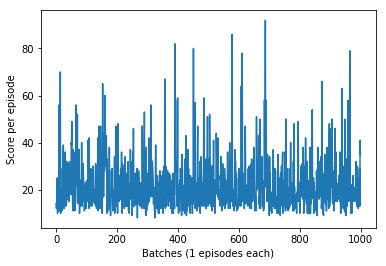

In [9]:
env = gym.make('CartPole-v0').unwrapped # remove TimeLimit wrapper

print('States:  ' + str(env.observation_space))
print('Actions: ' + str(env.action_space))

seed = 0
env.seed(seed)

agent = RandomAgent(env.observation_space.shape, env.action_space.n, random_state=seed)

train_batches(env, agent, num_batches=1000, batch_size=1, max_steps=1000, report_every=100, animate_every=100);

## <a id='1'></a> 1) REINFORCE: simplest implementation (no TensorFlow)

REINFORCE does not require a neural network, but can use any differentiable policy to convert states into actions. 

For educational purposes, let's look at a task with a simple binary output (e.g. move left vs move right). For this problem, we can use a logistic regression classifier for our policy representation. If we also restrict our problem to have two continuous states, we can easily simplify visualization of the learning process. 

<a href='#toc'>back to toc</a>

In [10]:
# logistic-regression based binary policy

class ReinforceBinaryLR(RLAgent):
    
    def __init__(self, state_size, action_size, discount_factor=0.99, learning_rate=0.01, random_state=None):
        
        # action space must be binary
        assert action_size == 2         
        super().__init__(state_size, action_size, discount_factor, learning_rate, random_state)
    
    def build_model(self):        
        # initialize weights of a logistic regression classifier (a "single neuron" network!)
        self.weights = np.random.randn(self.state_size[0])
        self.bias = np.random.randn(1)
            
    def act(self, state): 
        # sample action using output probabilities of classifier
        logit = np.dot(self.weights, state) + self.bias
        p_action = 1/(1 + np.exp(-logit))
        action = 1 if p_action > np.random.rand() else 0
        return action
    
    def train(self):
        # normalize rewards
        returns = np.squeeze(self.mem_rewards)        
        returns -= np.mean(returns)
        if returns.shape[0]>1:
            returns /= np.std(returns)
        
        states = np.vstack(self.mem_states)
        actions = np.squeeze(self.mem_actions)        
                
        # action probabilities 
        predictions = 1/(1 + np.exp(-(np.dot(states, self.weights) + self.bias)))        
        
        # compute gradient wrt weights using X * (Y-Yhat) -- but weighted by the returns/advantages        
        states = np.hstack((np.ones((states.shape[0], 1)), states)) # append ones for bias
        gradient = states * (actions-predictions).reshape(-1, 1)
        gradient *= returns.reshape(-1,1)
        gradient = gradient.sum(axis=0)
        
        # move up the gradient
        self.bias    += self.learning_rate*gradient[0]
        self.weights += self.learning_rate*gradient[1:]
                            
        # reset memory
        self.episode, self.episode_start = 0, 0
        self.mem_states, self.mem_actions, self.mem_rewards = [], [], []        
    

### <a name="1.1"></a>1.1) Performance on CartPole

<a href='#toc'>back to toc</a>

States:  Box(4,)
Actions: Discrete(2)
[0:00:00] batch: 1, score: 11
[0:00:01] batch: 10, score: 13
[0:00:02] batch: 20, score: 13
[0:00:03] batch: 30, score: 18
[0:00:05] batch: 40, score: 36
[0:00:06] batch: 50, score: 64
[0:00:09] batch: 60, score: 39
[0:00:10] batch: 70, score: 146
[0:00:14] batch: 80, score: 65
[0:00:18] batch: 90, score: 175
[0:00:30] batch: 100, score: 288
Completed 100 batches in 29 seconds (0% of time spent training)


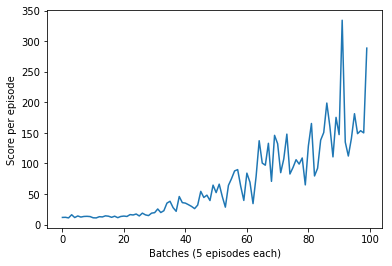

In [21]:
# example run CartPole with animation
env = gym.make('CartPole-v0').unwrapped # remove TimeLimit wrapper
# env = gym.wrappers.Monitor(env, "recording") # include this line to save animations to video folder

print('States:  ' + str(env.observation_space))
print('Actions: ' + str(env.action_space))

seed = 2018
env.seed(seed)

agent = ReinforceBinaryLR(env.observation_space.shape, env.action_space.n, random_state=seed)

train_batches(env, agent, num_batches=100, batch_size=5, max_steps=1000, report_every=10, animate_every=10);

### <a name="1.2"></a>1.2) Policy gradient has high variance

Let's see how much the algorithm varies for different random seeds.

<a href='#toc'>back to toc</a>

Run 1
Completed 300 batches in 7 seconds (9% of time spent training)
Run 2
Completed 300 batches in 2 seconds (10% of time spent training)
Run 3
Completed 300 batches in 4 seconds (9% of time spent training)
Run 4
Completed 300 batches in 3 seconds (9% of time spent training)
Run 5
Completed 300 batches in 5 seconds (9% of time spent training)
Run 6
Completed 300 batches in 9 seconds (9% of time spent training)
Run 7
Completed 300 batches in 3 seconds (10% of time spent training)
Run 8
Completed 300 batches in 6 seconds (9% of time spent training)
Run 9
Completed 300 batches in 1 seconds (10% of time spent training)
Run 10
Completed 300 batches in 3 seconds (9% of time spent training)
Complete!


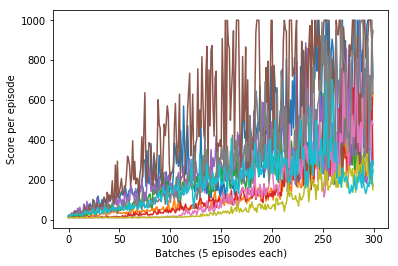

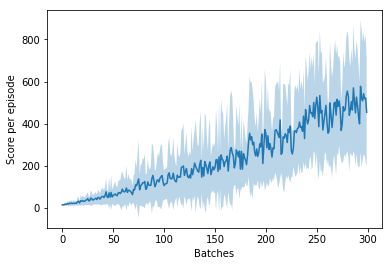

In [27]:
# loop
num_batches = 300
num_runs = 10
all_scores = np.zeros((num_batches, num_runs))

env = gym.make('CartPole-v0').unwrapped # remove TimeLimit wrapper
agent = ReinforceBinaryLR(env.observation_space.shape, env.action_space.n)

for i in range(num_runs):
    print('Run ' + str(i+1))
    
    # reset seed/agent
    env.seed(i)           
    np.random.seed(i)
    agent.random_state = i
    agent.build_model()    
    
    all_scores[:,i]  = train_batches(env, agent, num_batches=num_batches, batch_size=5, max_steps=1000)

print('Complete!')

plt.figure()
means = all_scores.mean(axis=1)
stds = all_scores.std(axis=1)
batches = np.arange(0,num_batches)
plt.plot(batches, means)
plt.fill_between(batches, means-stds, means+stds, alpha=0.3)
plt.ylabel('Score per episode')
plt.xlabel('Batches');

## <a id='2'></a>2) REINFORCE with a deep policy network (Tensorflow)

A deep-network policy gradient agent, which works with continuous state space and discrete actions.

<a href='#toc'>back to toc</a>

In [5]:
class ReinforceDeep(RLAgent):
    
    def __init__(self, state_size, action_size, discount_factor=0.99, learning_rate=0.01, hidden_dims=[], activation=tf.nn.relu,
                 choices=None, random_state=None):   
        
        # neural net parameters
        self.hidden_dims = hidden_dims
        self.activation = activation
        
        # only need one output unit if binary
        if action_size==2:
            action_size = 1
        
        super().__init__(state_size, action_size, discount_factor, learning_rate, random_state)
       
        
    def dense_nn(self, inputs, hidden_dims, output_dim, activation, name):
        # create a dense network with hidden layers
        layers = []
        x = inputs
        with tf.variable_scope(name):
            layers = []
            # hidden layers
            for (i, size) in enumerate(hidden_dims):
                layers.append(tf.layers.Dense(units=size,
                                              activation=activation,
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              name=name+'_l'+ str(i+1)))
                x = layers[i](x)
            
            # output layer (no activation)
            layers.append(tf.layers.Dense(units=output_dim,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name=name+'_l'+ str(len(self.hidden_dims)+1)))
            output = layers[-1](x)
            
        return output, layers            
        
    def build_model(self):
        tf.reset_default_graph()
        if self.random_state != 0:
            tf.set_random_seed(self.random_state)
        
        # input placeholders 
        self.states  = tf.placeholder(tf.float32, shape=(None,) + self.state_size, name='state')        
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='action')
        self.returns = tf.placeholder(tf.float32, shape=(None,), name='return')

        # build network
        self.pi, self.pi_layers = self.dense_nn(self.states, self.hidden_dims, 
                                                self.action_size, self.activation, name='pi_network')
                
        # sample actions using multinomial (softmax)     
        if self.action_size>1:
            self.sampled_actions = tf.squeeze(tf.multinomial(self.pi, 1))
        else: # or sigmoid if binary
            self.sampled_actions = tf.squeeze(tf.greater(tf.sigmoid(self.pi), tf.random_uniform(tf.shape(self.pi))))
        
        # advantage function = how "good" each action was compared to average
        # for less variance, replace this with a critic!
        self.advantages = tf.identity(self.returns)

        # loss function
        with tf.variable_scope('pi_optimize'):
            
            # negative log probabilities         
            if self.action_size>1:
                log_probs = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.pi, labels=self.actions)
            else: # binary
                log_probs = tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.squeeze(self.pi), labels=tf.to_float(self.actions))
            
            # multiply (weight) by advantages
            self.loss_pi = tf.reduce_mean(tf.stop_gradient(self.advantages)*log_probs, name='loss_pi')            
            self.optim_pi = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_pi, name='adam_optim_pi')
        
        # session and train ops
        self.train_ops = [self.optim_pi]
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())    
        
    
    def describe_model(self):
        
        print('States:  ' + str(self.state_size))
        
        totalweights = 0
        for (i, layer) in enumerate(self.pi_layers):
            nweights = np.sum([np.prod(x.get_shape().as_list()) for x in layer.trainable_weights])
            totalweights += nweights
            print('Layer %d: %d units, %d trainable weights' % (i, layer.units, nweights))
        
        print('---------------> %d total weights' % totalweights)
        
        nactions = self.action_size if self.action_size>1 else self.action_size+1        
        print('Actions: ' + str(nactions))
        
        
    def act(self, state): 
        # sample action using a feedforward pass through the network
        action = np.array(self.sess.run(self.sampled_actions, {self.states: [state]}), dtype=np.int32)        
        return action
    
    def train(self):

        # normalize rewards
        returns = np.squeeze(self.mem_rewards)        
        returns -= np.mean(returns)
        if returns.shape[0]>1:
            returns /= np.std(returns)
        
        self.sess.run(self.train_ops, feed_dict={
            self.states: np.vstack(self.mem_states),
            self.actions: np.squeeze(self.mem_actions),
            self.returns: np.array(returns)
        })
                            
        # reset memory
        self.episode, self.episode_start = 0, 0
        self.mem_states, self.mem_actions, self.mem_rewards = [], [], []

## <a name="2.1"></a>Better performance on CartPole
First let's test our deep network model on CartPole!

<a href='#toc'>back to toc</a>

In [39]:
env = gym.make('CartPole-v0').unwrapped # remove TimeLimit wrapper

print('States:  ' + str(env.observation_space))
print('Actions: ' + str(env.action_space))

hidden_dims = [8]
seed = 201
env.seed(seed)
agent = ReinforceDeep(env.observation_space.shape, 2, hidden_dims=hidden_dims, random_state=seed)
agent.describe_model()

train_batches(env, agent, num_batches=300, batch_size=5, max_steps=1000, report_every=50)
agent.sess.close()



States:  Box(4,)
Actions: Discrete(2)
States:  (4,)
Layer 0: 8 units, 40 trainable weights
Layer 1: 1 units, 9 trainable weights
---------------> 49 total weights
Actions: 2


Run 1
Completed 300 batches in 131 seconds (1% of time spent training)
Run 2
Completed 300 batches in 135 seconds (1% of time spent training)
Run 3
Completed 300 batches in 153 seconds (1% of time spent training)
Run 4
Completed 300 batches in 150 seconds (1% of time spent training)
Run 5
Completed 300 batches in 133 seconds (1% of time spent training)
Complete!


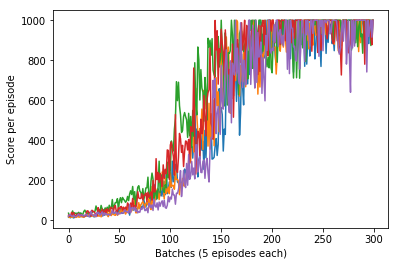

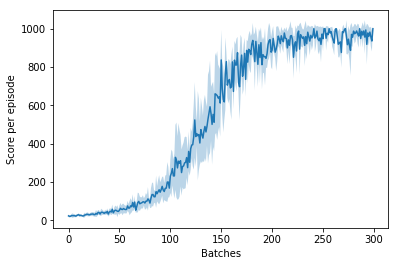

In [44]:
# loop
num_batches = 300
num_runs = 5
all_scores = np.zeros((num_batches, num_runs))

env = gym.make('CartPole-v0').unwrapped # remove TimeLimit wrapper
hidden_dims = [8]
agent = ReinforceDeep(env.observation_space.shape, 2, hidden_dims=hidden_dims)

for i in range(num_runs):
    print('Run ' + str(i+1))
    
    # reset seed/agent
    env.seed(i)           
    np.random.seed(i)
    agent.random_state = i
    agent.build_model()    
    
    all_scores[:,i]  = train_batches(env, agent, num_batches=num_batches, batch_size=5, max_steps=1000)
    agent.sess.close()

print('Complete!')

plt.figure()
means = all_scores.mean(axis=1)
stds = all_scores.std(axis=1)
batches = np.arange(0,num_batches)
plt.plot(batches, means)
plt.fill_between(batches, means-stds, means+stds, alpha=0.3)
plt.ylabel('Score per episode')
plt.xlabel('Batches');

Learning is faster than for the Logistic Regression agent, just by adding an 8-neuron hidden layer. 

(Notice that the fraction of time spent training is minimal -- most of it is spent processing trajectories through the environment. Future code should work on parallelizing this part: e.g. via https://gist.github.com/bamos/cedcc0165f2993f524fd839357b359cc )

But can we solve harder tasks?

### <a name="2.2"></a>Lunar Lander
A higher-dimensional task: 8 state dimensions, 4 actions

<a href='#toc'>back to toc</a>

States:  Box(8,)
Actions: Discrete(4)
States:  (8,)
Layer 0: 32 units, 288 trainable weights
Layer 1: 32 units, 1056 trainable weights
Layer 2: 4 units, 132 trainable weights
---------------> 1476 total weights
Actions: 4
[0:00:00] batch: 1, score: -186
[0:00:19] batch: 50, score: -92
[0:00:37] batch: 100, score: -134
[0:01:00] batch: 150, score: -128
[0:01:32] batch: 200, score: -56
[0:02:17] batch: 250, score: -68
[0:04:08] batch: 300, score: -51
[0:07:20] batch: 350, score: 3
[0:12:11] batch: 400, score: 18
[0:16:31] batch: 450, score: 23
[0:22:05] batch: 500, score: 24
Completed 500 batches in 1325 seconds (0% of time spent training)


[-186.0576625665592,
 -206.8621031972178,
 -176.61959523150819,
 -159.2959254534568,
 -112.19707826612898,
 -177.58061173311734,
 -158.24666058299786,
 -152.15427563980373,
 -141.13156359969838,
 -170.30172648556191,
 -150.54971132677966,
 -109.38365245470564,
 -166.37707256175796,
 -112.35394280373949,
 -140.37524306927878,
 -111.89119628791666,
 -180.4833176876994,
 -225.08598948615372,
 -120.25717030099813,
 -221.71231982916365,
 -127.42661749376529,
 -169.59656940582073,
 -160.95231861428493,
 -129.91051412964345,
 -150.231914045293,
 -113.53480430133789,
 -98.80692303610317,
 -114.70246886945736,
 -160.1226867992445,
 -99.51514167610819,
 -147.19043189669767,
 -116.57784507480127,
 -121.33568516583611,
 -103.15844908463846,
 -154.40088024666335,
 -190.40408220459835,
 -120.69300724014984,
 -163.25230569616517,
 -130.66318806932802,
 -121.09327015062722,
 -131.21441489312645,
 -148.10137704533724,
 -132.03373449273533,
 -146.5871052678055,
 -126.17640922462797,
 -149.67526001129562

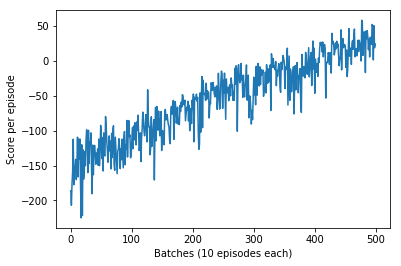

In [33]:
env = gym.make('LunarLander-v2')
print('States:  ' + str(env.observation_space))
print('Actions: ' + str(env.action_space))

hidden_dims = [32, 32]
seed = 2018
env.seed(seed)
agent = ReinforceDeep(env.observation_space.shape, env.action_space.n, hidden_dims=hidden_dims, random_state=seed, learning_rate=0.001)
agent.describe_model()

train_batches(env, agent, num_batches=500, batch_size=10, max_steps=1000, report_every=50, animate_every=0)
# agent.sess.close()

Making steady progress after 500 batches, though I'm too impatient to wait longer...

[0:01:20] batch: 1, score: 60
Completed 1 batches in 80 seconds (0% of time spent training)


[60.449333219424624]

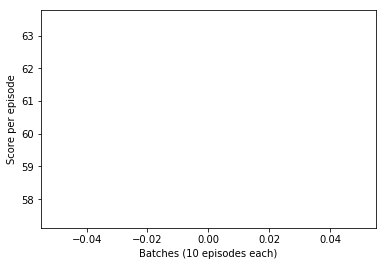

In [43]:
# animate and save video!
env = gym.make('LunarLander-v2')
env = gym.wrappers.Monitor(env, "lunar") # include this line to save animations to video folder
train_batches(env, agent, num_batches=1, batch_size=10, max_steps=1000, report_every=1, animate_every=1)

## <a name="2.3"></a> Pong from pixels using a CNN

Let's change the "dense_nn" to a conv net for Pong.

<a href='#toc'>back to toc</a>


In [6]:
class ReinforceConv(ReinforceDeep):
    
    def dense_nn(self, inputs, hidden_dims, output_dim, activation, name):
        
        # replace dense network with a convolutional network
        layers = []
        x = inputs
        with tf.variable_scope(name):
            layers = []
            # hidden layers: interleave Conv and MaxPooling
            for (i, size) in enumerate(hidden_dims):
                
                layers.append(tf.layers.Conv2D(filters=size,
                                               kernel_size=(3,3),
                                               activation=activation,
                                               padding='same',
                                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                               name=name+'_c'+ str(i+1)))
                x = layers[-1](x)
                
                layers.append(tf.layers.MaxPooling2D(pool_size=(2,2),
                                                     strides=(2,2),
                                                     name=name+'_p'+ str(i+1)))
                
                x = layers[-1](x)
            
                    
            # output layer (no activation)
            layers.append(tf.layers.Dense(units=output_dim,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name=name+'_l'+ str(len(self.hidden_dims)+1)))
            x = tf.layers.flatten(x) # flatten first
            output = layers[-1](x)
            
        return output, layers      
    
    def train(self):

        # normalize rewards
        returns = np.squeeze(self.mem_rewards)        
        returns -= np.mean(returns)
        if returns.shape[0]>1:
            returns /= np.std(returns)
        
        states = np.expand_dims(np.moveaxis(np.dstack(agent.mem_states),-1,0),3)
        
        self.sess.run(self.train_ops, feed_dict={
            self.states: states,
            self.actions: np.squeeze(self.mem_actions),
            self.returns: np.array(returns)
        })
                            
        # reset memory
        self.episode, self.episode_start = 0, 0
        self.mem_states, self.mem_actions, self.mem_rewards = [], [], []
        
        
    
    def describe_model(self):
        
        print('States:  ' + str(self.state_size))
        
        totalweights = 0
        for (i, layer) in enumerate(self.pi_layers):
            nweights = np.sum([np.prod(x.get_shape().as_list()) for x in layer.trainable_weights])
            totalweights += nweights
            if hasattr(layer, 'filters'):
                print('Layer %d: %d filters, %d trainable weights' % (i, layer.filters, nweights))
            elif hasattr(layer, 'units'):
                print('Layer %d: %d units, %d trainable weights' % (i, layer.units, nweights))
        
        print('---------------> %d total weights' % totalweights)
        
        nactions = self.action_size if self.action_size>1 else self.action_size+1        
        print('Actions: ' + str(nactions))

Andrej Karpathy's version uses 200 fully connected units and takes 3 days to train. http://karpathy.github.io/2016/05/31/rl/

Can we do better with a CNN?

In [17]:
env = gym.make("Pong-v0")

# we need to write a function that can process the input images
def process_pong_state(state, reset=False):
    if not hasattr(process_pong_state, 'prevI') or reset:
        process_pong_state.prevI = np.zeros((80, 80, 1))
    
    I = deepcopy(state)
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    I = np.expand_dims(I, 2) # single color channel
        
    dI = I - process_pong_state.prevI # return difference with previous state
    process_pong_state.prevI = I # store state
    return dI

# only use actions 2 (down) or 3 (up)
process_pong_action = lambda a: 3 if a==1 else 2

hidden_dims = [8, 16, 32]
seed = 100
env.seed(seed)
agent = ReinforceConv((80, 80, 1), 2, hidden_dims=hidden_dims, random_state=seed, learning_rate=0.001)
agent.describe_model()

# scores = train_batches(env, agent, num_batches=2000, batch_size=5, max_steps=2000, report_every=10, animate_every=0,
#              process_state=process_pong_state, process_action=process_pong_action)
# agent.sess.close()


States:  (80, 80, 1)
Layer 0: 8 filters, 80 trainable weights
Layer 2: 16 filters, 1168 trainable weights
Layer 4: 32 filters, 4640 trainable weights
Layer 6: 1 units, 3201 trainable weights
---------------> 9089 total weights
Actions: 2


[0:00:23] batch: 1, score: -5
[0:03:34] batch: 10, score: -4
[0:07:00] batch: 20, score: -3
[0:10:18] batch: 30, score: -3
[0:13:46] batch: 40, score: -5
[0:17:14] batch: 50, score: -5
[0:20:45] batch: 60, score: -2
[0:24:06] batch: 70, score: -4
[0:27:27] batch: 80, score: -1
[0:31:06] batch: 90, score: -3
[0:34:38] batch: 100, score: -6
[0:38:17] batch: 110, score: -4
[0:41:55] batch: 120, score: -4
[0:45:37] batch: 130, score: -4
[0:49:00] batch: 140, score: -5
[0:52:25] batch: 150, score: -4
[0:55:52] batch: 160, score: -3
[0:59:23] batch: 170, score: -2
[1:02:50] batch: 180, score: -2
[1:06:26] batch: 190, score: -2
[1:10:02] batch: 200, score: -2
Completed 200 batches in 4201 seconds (43% of time spent training)


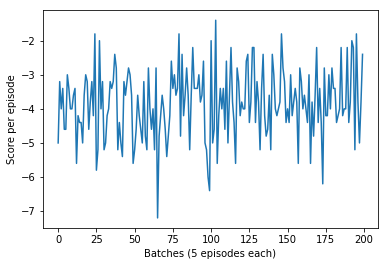

In [32]:
# retrain more (outcome of earlier training rounds not shown...)
agent.mem_actions, agent.mem_states, agent.mem_rewards = [], [], []
scores = train_batches(env, agent, num_batches=200, batch_size=5, max_steps=1500, report_every=10, animate_every=0,
             process_state=process_pong_state, process_action=process_pong_action)

## <a name='3'></a>3) REINFORCE and other algorithms using OpenAI's Spinning Up

This is just basic starter code. See https://spinningup.openai.com/en/latest/ for more info. You can run REINFORCE (Vanilla Policy Gradient, vpg) or more advanced algos like Proximal Policy Optimization (PPO).

In [ ]:
spinup_path = '/home/gpho/packages/spinningup'

os.chdir(spinup_path)


In [ ]:
# code for running outside jupyter notebook
!python -m spinup.run ppo --exp_name ppo_swim --env Swimmer-v2 --hid "[64, 32]" --act tf.nn.tanh --seed 0 10 20 --dt


In [ ]:
# code for running inside jupyter notebook
tf.reset_default_graph()

env_fn = lambda : gym.make('HalfCheetah-v2')
ac_kwargs = dict(hidden_sizes=[64,32], activation=tf.nn.tanh)
logger_kwargs = dict(output_dir='log/HalfCheetah/', exp_name='ppo')

ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=4000, epochs=25, logger_kwargs=logger_kwargs)

In [ ]:
from spinup.utils.plot import make_plots
from spinup.utils.test_policy import load_policy, run_policy

nb_path = os.getcwd()
spinup_path = '~/packages/spinningup'

# helper functions for use in ipython notebook
def spinup_plot(logdir, legend=None, xaxis='TotalEnvInteracts', value='Performance', count=False, smooth=1, select=None, exclude=None, est='mean'):
    if not isinstance(logdir, list):
        logdir = [logdir]
    if legend is not None and not isinstance(legend, list):
        legend = [legend]
        
    make_plots(logdir, legend=legend, xaxis=xaxis, values=value, count=count, smooth=smooth, select=select, exclude=exclude, estimator=est)    
    
def spinup_test(fpath, length=0, episodes=100, norender=False, itr=-1, deterministic=False):
    env, get_action = load_policy(fpath, 
                                  itr if itr >=0 else 'last',
                                  deterministic)
    run_policy(env, get_action, length, episodes, not(norender))
    


In [ ]:
spinup_plot('log/HalfCheetah/')